## 2e. Calculate closed-system degassing paths for different volatile systems.

## Setting things up
You need to install VolFe once on your machine, if you haven't yet. Then we need to import a few Python packages (including VolFe). 

In [ ]:
# Install VolFe on your machine. Remove the # from line below to do this (don't remove the # from this line!).
# pip install VolFe

In [1]:
# Install VolFe on your machine. Don't remove the # from this line!
# pip install VolFe # Remove the first # in this line if you have not installed VolFe on your machine before.

# import python packages
import pandas as pd
import matplotlib.pyplot as plt
import VolFe as vf

These are some examples where the volatiles aren't C, H, and S. These types of calculations can be done for open- and closed-system, re- and degassing paths as described in Examples 2a-d, but we'll just show them for closed-system degassing paths where the inputted composition represents the bulk composition of the system.

For the volatile-free melt composition, we'll use Sari15-04-33 from Brounce et al. (2014) at 1200 'C as before, but we will specify different volatile concentrations. 

First, we'll model CHOAr degassing - i.e., carbon, hydrogen, and argon are the volatiles of interest (no sulfur - at the moment it isn't possible to run CHOS and a noble gas).

In this case the initial volatile content is 500 ppm CO2, 2 wt% H2O, and 10 ppm Ar.

The Ar amount is inputted for the "X" species.

In [2]:
# Define the melt composition, fO2 estimate, and T as a dictionary.
my_analysis = {'Sample':'Sari15-04-33',
           'T_C': 1200., # Temperature in 'C
           'SiO2': 47.89, # wt%
           'TiO2': 0.75, # wt%
           'Al2O3': 16.74, # wt%
           'FeOT': 9.43, # wt%
           'MnO': 0.18, # wt%
           'MgO': 5.92, # wt%
           'CaO': 11.58, # wt%
           'Na2O': 2.14, # wt%
           'K2O': 0.63, # wt%
           'P2O5': 0.17, # wt%
           'H2O': 2., # wt%
           'CO2ppm': 500., # ppm
           'STppm': 0., # ppm
           'Xppm': 10., # ppm <<< treating this as Ar
           'Fe3FeT': 0.195}

# Turn the dictionary into a pandas dataframe, setting the index to 0.
my_analysis = pd.DataFrame(my_analysis, index=[0])

We'll use the default options, but the important options for noble gas modelling are:

**species X** where the default is Ar (*Ar*)

**species X solubility** where the default is for Ar in basalt (*Ar_Basalt_HughesIP*)

Both these defaults are fine for this example, but you can change them to Ar in rhyolite (*Ar_Rhyolite_HughesIP*) or Ne (*Ne*) for basalt (*Ne_Basalt_HughesIP*) or rhyolite (*Ne_Rhyolite_HughesIP*).

Note: Currently, this only solves to P = 70 bar.

In [3]:
degas1 = vf.calc_gassing(my_analysis)

/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/equilibrium_equations.py:2141: RuntimeWarning: invalid value encountered in scalar power
  xm_H2O_ = (K4_*y_H2O_*xg_H2O_*P)**0.5


tried resetting guesses
solver failed, decreasing step size by factor 10


/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/differential_equations.py:471: RuntimeWarning: invalid value encountered in scalar power
  result = (-K11_*P*xg_CO_*y_CO_/M_CO - 0.25*K12_*K2_*P*xg_CO_*y_CO_*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K3_*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + xg_O2_ + xg_X_ - 1.0)/(K3_*y_CH4_) + 0.25*(1.0 + y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))**2.0)**0.5 - 1.0 - y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))/(K2_*xg_CO_*y_CO_))**2.0/(K3_*M_CH4) - K2_*K5_*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/(K2_*K5_*M_CO2*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5 + 0.707106781186548*M_H2O*(K3_*K4_*P*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + x

solver failed, calculation aborted at P =  69.0 2024-09-16 20:42:31.155752


Next for Ne in basalt

Note: Currently, this only solves to P = 120 bar.

In [4]:
# choose the options I want - everything else will use the default options
my_models = [['species X','Ne'],['species X solubility','Ne_Basalt_HughesIP']]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

# run calculation
degas2 = vf.calc_gassing(my_analysis,models=my_models)

/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/equilibrium_equations.py:2141: RuntimeWarning: invalid value encountered in scalar power
  xm_H2O_ = (K4_*y_H2O_*xg_H2O_*P)**0.5


tried resetting guesses
solver failed, decreasing step size by factor 10


/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/differential_equations.py:471: RuntimeWarning: invalid value encountered in scalar power
  result = (-K11_*P*xg_CO_*y_CO_/M_CO - 0.25*K12_*K2_*P*xg_CO_*y_CO_*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K3_*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + xg_O2_ + xg_X_ - 1.0)/(K3_*y_CH4_) + 0.25*(1.0 + y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))**2.0)**0.5 - 1.0 - y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))/(K2_*xg_CO_*y_CO_))**2.0/(K3_*M_CH4) - K2_*K5_*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/(K2_*K5_*M_CO2*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5 + 0.707106781186548*M_H2O*(K3_*K4_*P*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + x

solver failed, calculation aborted at P =  119.0 2024-09-16 20:43:03.985033


Or Ar in rhyolite

Note: Currently, this only solves to P = 100 bar.

In [5]:
# choose the options I want - everything else will use the default options
my_models = [['species X solubility','Ar_Rhyolite_HughesIP']]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

# run calculation
degas3 = vf.calc_gassing(my_analysis,models=my_models)

/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/equilibrium_equations.py:2141: RuntimeWarning: invalid value encountered in scalar power
  xm_H2O_ = (K4_*y_H2O_*xg_H2O_*P)**0.5


tried resetting guesses
solver failed, decreasing step size by factor 10


/Users/ehughes/Documents/GitHub/VolFe/src/VolFe/differential_equations.py:471: RuntimeWarning: invalid value encountered in scalar power
  result = (-K11_*P*xg_CO_*y_CO_/M_CO - 0.25*K12_*K2_*P*xg_CO_*y_CO_*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K3_*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + xg_O2_ + xg_X_ - 1.0)/(K3_*y_CH4_) + 0.25*(1.0 + y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))**2.0)**0.5 - 1.0 - y_H2O_*(P*xg_O2_*y_O2_)**(-0.5)/(K1_*y_H2_))/(K2_*xg_CO_*y_CO_))**2.0/(K3_*M_CH4) - K2_*K5_*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/(K2_*K5_*M_CO2*P*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5 + 0.707106781186548*M_H2O*(K3_*K4_*P*y_CH4_*y_H2O_**(-1.0)*(xg_O2_*y_O2_)**2.0*(P*xg_O2_*y_O2_)**(-0.5)*(2.0*(-K2_*xg_CO_*y_CO_*y_H2O_**2.0*(xg_O2_*y_O2_)**(-2.0)*(P*xg_O2_*y_O2_)**0.5*(K2_*xg_CO_*y_CO_*(P*xg_O2_*y_O2_)**0.5/y_CO2_ + xg_CO_ + x

solver failed, calculation aborted at P =  99.0 2024-09-16 20:43:28.274495


And plot for comparison (not the calculations failed at about ~70-120 bar so they didn't quite reach the surface).

(1500.0, 0.0)

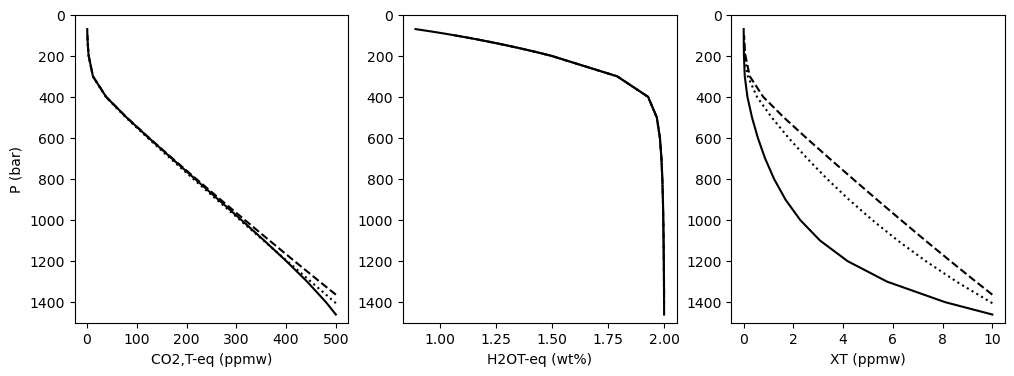

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

data1 = degas1 # Ar in basalt
data2 = degas2 # Ne in basalt
data3 = degas3 # Ar in rhyolite

# Plotting results
ax1.plot(data1['CO2T-eq_ppmw'], data1['P_bar'], '-k')
ax1.plot(data2['CO2T-eq_ppmw'], data2['P_bar'], ':k')
ax1.plot(data3['CO2T-eq_ppmw'], data3['P_bar'], '--k')
ax2.plot(data1['H2OT-eq_wtpc'], data1['P_bar'], '-k')
ax2.plot(data2['H2OT-eq_wtpc'], data2['P_bar'], ':k')
ax2.plot(data3['H2OT-eq_wtpc'], data3['P_bar'], '--k')
ax3.plot(data1['X_ppmw'], data1['P_bar'], '-k')
ax3.plot(data2['X_ppmw'], data2['P_bar'], ':k')
ax3.plot(data3['X_ppmw'], data3['P_bar'], '--k')

ax1.set_ylabel('P (bar)')
ax1.set_xlabel('CO2,T-eq (ppmw)')
ax2.set_xlabel('H2OT-eq (wt%)')
ax3.set_xlabel('XT (ppmw)')
ax1.set_ylim([1500,0])
ax2.set_ylim([1500,0])
ax3.set_ylim([1500,0])

Alternatively, we could just look at degassing in the HSO system (i.e., no CO2 or X)

In [7]:
# Define the melt composition, fO2 estimate, and T as a dictionary.
my_analysis = {'Sample':'Sari15-04-33',
           'T_C': 1200., # Temperature in 'C
           'SiO2': 47.89, # wt%
           'TiO2': 0.75, # wt%
           'Al2O3': 16.74, # wt%
           'FeOT': 9.43, # wt%
           'MnO': 0.18, # wt%
           'MgO': 5.92, # wt%
           'CaO': 11.58, # wt%
           'Na2O': 2.14, # wt%
           'K2O': 0.63, # wt%
           'P2O5': 0.17, # wt%
           'H2O': 2., # wt%
           'CO2ppm': 0., # ppm
           'STppm': 1000., # ppm
           'Xppm': 0., # ppm
           'Fe3FeT': 0.195}

# Turn the dictionary into a pandas dataframe, setting the index to 0.
my_analysis = pd.DataFrame(my_analysis, index=[0])

In [8]:
degas4 = vf.calc_gassing(my_analysis)

Or CSO system

In [9]:
# Define the melt composition, fO2 estimate, and T as a dictionary.
my_analysis = {'Sample':'Sari15-04-33',
           'T_C': 1200., # Temperature in 'C
           'SiO2': 47.89, # wt%
           'TiO2': 0.75, # wt%
           'Al2O3': 16.74, # wt%
           'FeOT': 9.43, # wt%
           'MnO': 0.18, # wt%
           'MgO': 5.92, # wt%
           'CaO': 11.58, # wt%
           'Na2O': 2.14, # wt%
           'K2O': 0.63, # wt%
           'P2O5': 0.17, # wt%
           'H2O': 0., # wt%
           'CO2ppm': 500., # ppm
           'STppm': 1000., # ppm
           'Xppm': 0., # ppm
           'Fe3FeT': 0.195}

# Turn the dictionary into a pandas dataframe, setting the index to 0.
my_analysis = pd.DataFrame(my_analysis, index=[0])

In [10]:
degas5 = vf.calc_gassing(my_analysis)

And compare!

(1200.0, 0.0)

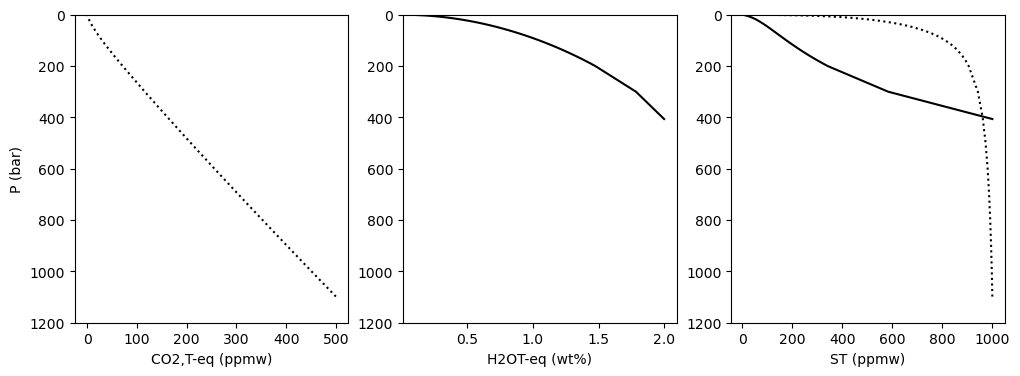

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

data1 = degas4 # HSO
data2 = degas5 # CSO

# Plotting results
ax1.plot(data2['CO2T-eq_ppmw'], data2['P_bar'], ':k')
ax2.plot(data1['H2OT-eq_wtpc'], data1['P_bar'], '-k')
ax3.plot(data1['ST_ppmw'], data1['P_bar'], '-k')
ax3.plot(data2['ST_ppmw'], data2['P_bar'], ':k')

ax1.set_ylabel('P (bar)')
ax1.set_xlabel('CO2,T-eq (ppmw)')
ax2.set_xlabel('H2OT-eq (wt%)')
ax3.set_xlabel('ST (ppmw)')
ax1.set_ylim([1200,0])
ax2.set_ylim([1200,0])
ax3.set_ylim([1200,0])